## Project 1 – Parts g & h: Bias–Variance with Bootstrap and Cross‑Validation

# Imports og hjelpefunksjoner

In [1]:
from functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

seed = 2018

# Make dataset

In [2]:
n_points = 2000

degrees = list(range(1, 16)) #polynomial degrees

n_boots_reps = 300 #number of bootstrap replicates
n_k_folds = 10 #number of k-folds

#ridge_lambdas = np.logspace(-4, 2, 15) #alpha eller lambda, feilen "straffen" i ridge
#lasso_lambdas = np.logspace(-4, 2, 15) #alpha eller lambda, feilen "straffen" i lasso
lambdas = np.logspace(-4, 2, 15) #feilen "straffen" i ridge og lasso

# Lag datasett
(train, test, full) = make_data(n=n_points)

x_train, y_train = train
x_test, y_test = test
x_all, y_all, y_all_clean = full 

x_grid = np.linspace(-1, 1, 400) 

# Define function for calculating OLS

In [3]:
def ols(x_train, y_train, x_eval, degree):    
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=True), 
        LinearRegression(fit_intercept=False))    

    model.fit(x_train.reshape(-1, 1), y_train)  
    y_predicted = model.predict(x_eval.reshape(-1, 1)).ravel()    

    return y_predicted, model

# Del g: Bootstrap-estimat av Bias, Varians og MSE (OLS)

For hver polynomgrad d trener du OLS mange ganger på bootstrap-utvalg av treningsdataene. Hver gang predikerer du en hel kurve på et fast grid av x-verdier. Deretter bruker du disse mange kurvene til å anslå bias^2, varians og mse som funksjon av x (og til slutt snitter du over gridet for å få ett tall per grad).

In [4]:
boot_results = bootstrap(degrees, x_train, x_test, y_train, y_test, x_grid, n_boots_reps)

deg, bias2_boots, var_boots, mse_boots, train_mse, test_mse = (
    boot_results["degree"],
    boot_results["bias2_boots"],
    boot_results["var_boots"],
    boot_results["mse_boots"],
    boot_results["train_mse"],
    boot_results["test_mse"],
)

# Plott: Train/Test-MSE vs grad (OLS)

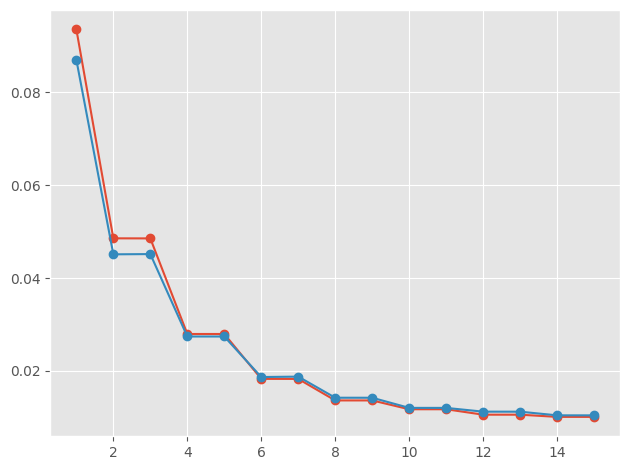

In [5]:
plt.figure()
plt.plot(deg, train_mse, marker='o', label='Train MSE (noisy)')
plt.plot(deg, test_mse, marker='o', label='Test MSE (noisy)')
#plt.xlabel('Polynomial degree')
#plt.ylabel('MSE')
#plt.title('Train/Test MSE vs Degree (OLS)')
#plt.legend()
plt.tight_layout()
plt.show()

# Plott: Bias², Varians, MSE (bootstrap) vs grad

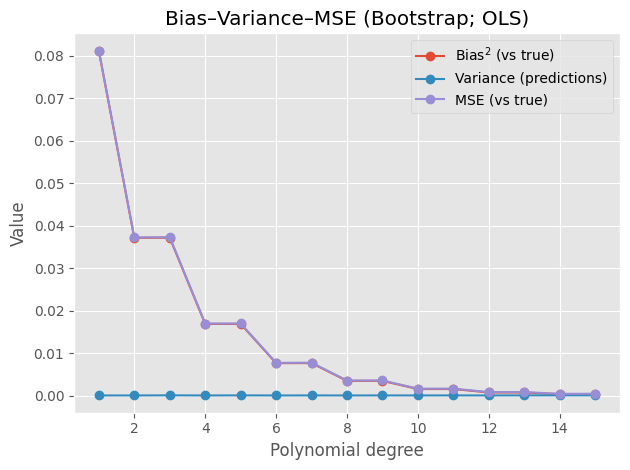

In [6]:
plt.figure()
plt.plot(deg, bias2_boots, marker='o', label='Bias$^2$ (vs true)')
plt.plot(deg, var_boots, marker='o', label='Variance (predictions)')
plt.plot(deg, mse_boots, marker='o', label='MSE (vs true)')
plt.xlabel('Polynomial degree'); plt.ylabel('Value')
plt.title('Bias–Variance–MSE (Bootstrap; OLS)')
plt.legend()
plt.tight_layout()
plt.show()

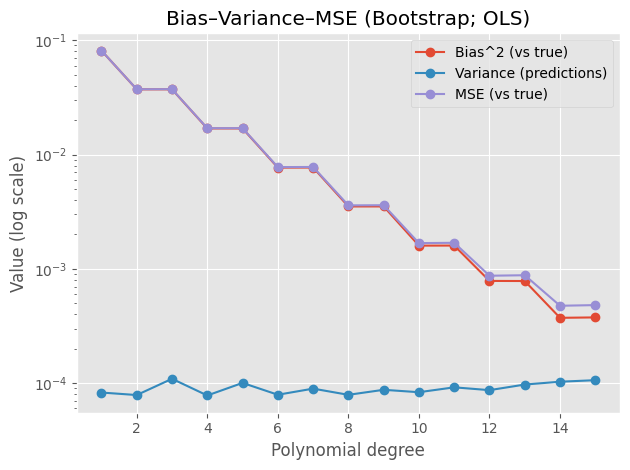

In [7]:
plt.figure()
plt.semilogy(deg, bias2_boots, marker='o', label='Bias^2 (vs true)')
plt.semilogy(deg, var_boots,   marker='o', label='Variance (predictions)')
plt.semilogy(deg, mse_boots,   marker='o', label='MSE (vs true)')
plt.xlabel('Polynomial degree'); plt.ylabel('Value (log scale)')
plt.title('Bias–Variance–MSE (Bootstrap; OLS)')
plt.legend(); plt.tight_layout(); plt.show()

In [8]:
for d, b2, v, m in zip(deg, bias2_boots, var_boots, mse_boots):
    if d in [0,1,2,3,4]:
        print(f"degree {d:2d}: bias^2={b2:.4f}, var={v:.4f}, mse={m:.4f}, sum={b2+v:.4f}")

degree  1: bias^2=0.0811, var=0.0001, mse=0.0812, sum=0.0812
degree  2: bias^2=0.0372, var=0.0001, mse=0.0372, sum=0.0372
degree  3: bias^2=0.0372, var=0.0001, mse=0.0373, sum=0.0373
degree  4: bias^2=0.0169, var=0.0001, mse=0.0170, sum=0.0170


# Del h: k-fold CV for OLS – MSE vs grad

In [9]:
cv_mse_ols = np.array([kfold_cv_mse_ols(d, n_k_folds, x_train, y_train) for d in degrees])

# Plot

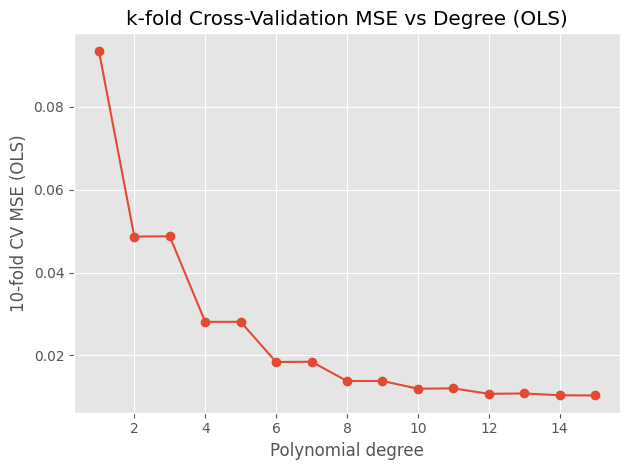

The best polynomial degree for ols is 15


In [10]:
plt.figure()
plt.plot(degrees, cv_mse_ols, marker='o')
plt.xlabel('Polynomial degree')
plt.ylabel(f'{n_k_folds}-fold CV MSE (OLS)')
plt.title('k-fold Cross-Validation MSE vs Degree (OLS)')
plt.tight_layout()
plt.show()
best_deg_ols = int(degrees[np.argmin(cv_mse_ols)])

print(f"The best polynomial degree for ols is {best_deg_ols}")

# CV-kurver for Ridge og Lasso (utvalgte grader)

In [12]:
best_ridge, best_lasso = {}, {}

cv_mse_ridge = {d: cv_for_methods('ridge', d, lambdas, n_k_folds, x_train, y_train)
for d in degrees}
cv_mse_lasso = {d: cv_for_methods('lasso', d, lambdas, n_k_folds, x_train, y_train) 
for d in degrees}

# Plot

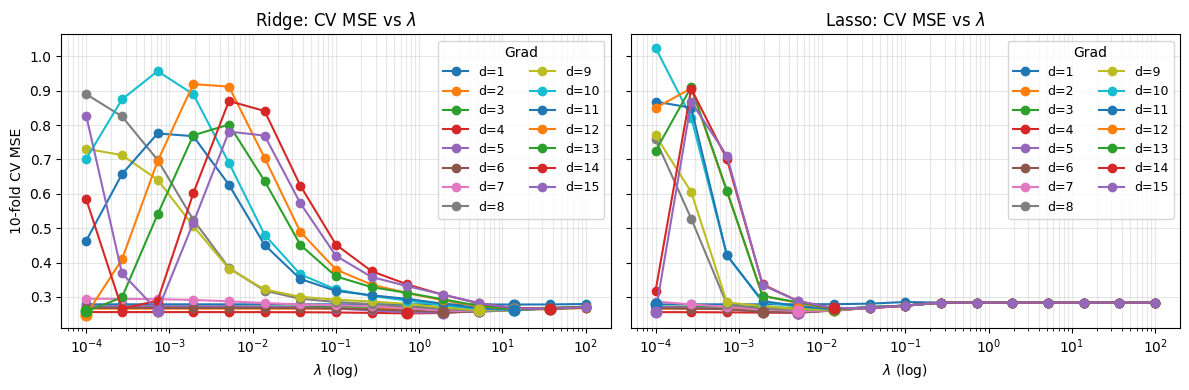

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey = True)
ax_ridge, ax_lasso = axes 

#Ridge 
for d in degrees:
    results_ridge = cv_mse_ridge[d]
    order = np.argsort(results_ridge["lambdas"])
    ax_ridge.semilogx(results_ridge["lambdas"][order], results_ridge["cv_mse"][order], marker='o', linewidth=1.5, label=f'd={d}')
    ax_ridge.scatter(results_ridge["best_lambda"], results_ridge["best_mse"], s=60, zorder=3)

ax_ridge.set_title(r'Ridge: CV MSE vs $\lambda$')
ax_ridge.set_xlabel(r'$\lambda$ (log)')
ax_ridge.set_ylabel(f'{n_k_folds}-fold CV MSE')
ax_ridge.grid(True, which='both', alpha=0.3)
ax_ridge.legend(title='Grad', ncol=2, fontsize=9)


# Lasso
for d in degrees:
    results_lasso = cv_mse_lasso[d]
    order = np.argsort(results_lasso["lambdas"])
    ax_lasso.semilogx(results_lasso["lambdas"][order], results_lasso["cv_mse"][order], marker='o', linewidth=1.5, label=f'd={d}')
    ax_lasso.scatter(results_lasso["best_lambda"], results_lasso["best_mse"], s=60, zorder=3)

ax_lasso.set_title(r'Lasso: CV MSE vs $\lambda$')
ax_lasso.set_xlabel(r'$\lambda$ (log)')
ax_lasso.grid(True, which='both', alpha=0.3)
ax_lasso.legend(title='Grad', ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

# Sammenlign OLS/Ridge/Lasso og vis beste modeller

In [ ]:
best_ridge = cv_mse_ridge
best_lasso = cv_mse_lasso

rows = []
for d in degrees:
    ols_cv_mse = kfold_cv_mse_ols(d, n_k_folds, x_train, y_train)

    rr = best_ridge[d]; ll = best_lasso[d]
    rows.append({
        "degree": d,
        "ols_cv_mse": ols_cv_mse,
        "ridge_best_lambda": rr["best_lambda"],
        "ridge_best_mse": rr["best_mse"],
        "lasso_best_lambda": ll["best_lambda"],
        "lasso_best_mse": ll["best_mse"],
    })
summary_df = pd.DataFrame(rows).sort_values("degree").reset_index(drop=True)

summary_df

,degree,ols_cv_mse,ridge_best_lambda,ridge_best_mse,lasso_best_lambda,lasso_best_mse
0,1,0.278304,13.894955,0.277761,0.000100,0.278305
1,2,0.265609,13.894955,0.263295,0.005179,0.265485
2,3,0.271591,37.275937,0.265704,0.013895,0.266109
3,4,0.255731,0.719686,0.251935,0.005179,0.253230
4,5,0.272514,1.930698,0.253918,0.005179,0.253962
5,6,0.267858,1.930698,0.256511,0.001931,0.256132
6,7,0.294861,5.179475,0.257811,0.005179,0.258353
7,8,0.934665,5.179475,0.259369,0.013895,0.261462
8,9,0.729350,5.179475,0.261423,0.013895,0.261978
9,10,0.376382,13.894955,0.261594,0.013895,0.263628


# Plott: Metodesammenligning (CV-MSE)

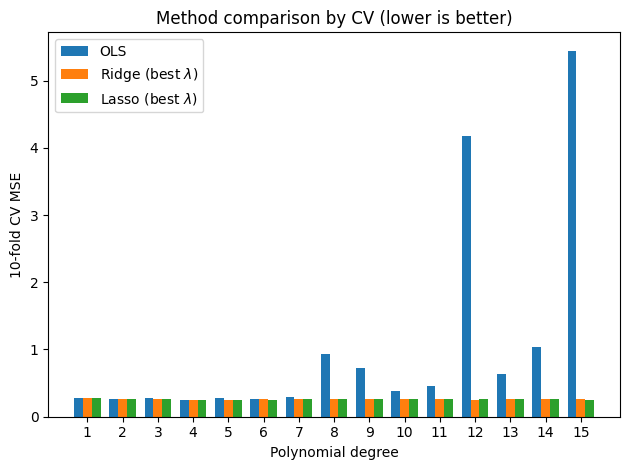

In [ ]:
idx = np.arange(len(summary_df))
width = 0.25 

plt.figure()
plt.bar(idx - width, summary_df["ols_cv_mse"], width=width, label='OLS')
plt.bar(idx,         summary_df["ridge_best_mse"], width=width, label=r'Ridge (best $\lambda$)')
plt.bar(idx + width, summary_df["lasso_best_mse"], width=width, label=r'Lasso (best $\lambda$)')
plt.xticks(idx, [str(d) for d in summary_df["degree"]])
plt.xlabel('Polynomial degree')
plt.ylabel(f'{n_k_folds}-fold CV MSE')
plt.title('Method comparison by CV (lower is better)')
plt.legend()
plt.tight_layout()
plt.show()

# Tren beste modeller og rapporter hold-out Test-MSE

OLS (deg=4) Test MSE: 0.220139
Ridge (deg=12, alpha=1.000e-04) Test MSE: 0.259594
Lasso (deg=4, alpha=5.179e-03) Test MSE: 0.246481


<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_8819/2658137429.py:34: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (deg={best_deg_ridge}, $\lambda$={best_lambda_ridge:.2e})')
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_8819/2658137429.py:35: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (deg={best_deg_lasso}, $\lambda$={best_lambda_lasso:.2e})')


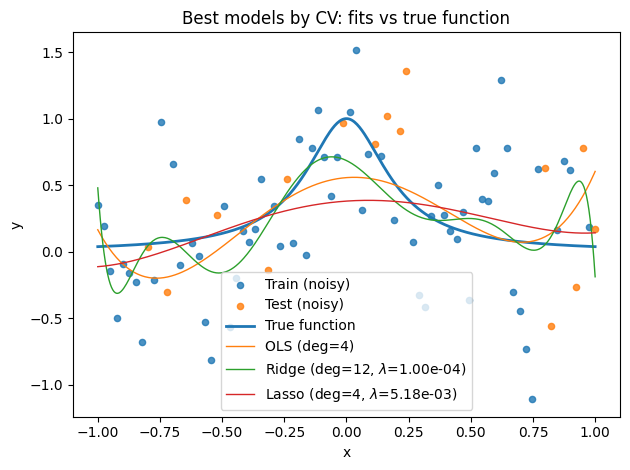

In [ ]:
# Finn beste grad for OLS fra CV
best_deg_ols = int(degrees[np.argmin(cv_mse_ols)])

# Velg beste grad/alpha for Ridge og Lasso fra tabellen
best_deg_ridge = int(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["degree"])
best_lambda_ridge = float(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["ridge_best_lambda"])
best_deg_lasso = int(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["degree"])
best_lambda_lasso = float(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["lasso_best_lambda"])

# Fit modeller
x_dense = np.linspace(-1, 1, 400)
ols_model = make_pipeline(PolynomialFeatures(degree=best_deg_ols, include_bias=True), LinearRegression(fit_intercept=False))
ols_model.fit(x_train.reshape(-1,1), y_train)
ridge_model = make_pipeline(PolynomialFeatures(degree=best_deg_ridge, include_bias=False), Ridge(alpha=best_lambda_ridge, fit_intercept=True, random_state=seed))
ridge_model.fit(x_train.reshape(-1,1), y_train)
lasso_model = make_pipeline(PolynomialFeatures(degree=best_deg_lasso, include_bias=False), Lasso(alpha=best_lambda_lasso, fit_intercept=True, max_iter=200_000_000, tol=5e-3, selection="cyclic", random_state=seed))
lasso_model.fit(x_train.reshape(-1,1), y_train)

# Test-MSE på hold-out
ols_test_mse   = mse(y_test, ols_model.predict(x_test.reshape(-1,1)).ravel())
ridge_test_mse = mse(y_test, ridge_model.predict(x_test.reshape(-1,1)).ravel())
lasso_test_mse = mse(y_test, lasso_model.predict(x_test.reshape(-1,1)).ravel())

print(f"OLS (deg={best_deg_ols}) Test MSE: {ols_test_mse:.6f}")
print(f"Ridge (deg={best_deg_ridge}, alpha={best_lambda_ridge:.3e}) Test MSE: {ridge_test_mse:.6f}")
print(f"Lasso (deg={best_deg_lasso}, alpha={best_lambda_lasso:.3e}) Test MSE: {lasso_test_mse:.6f}")

# Plot beste fits
plt.figure()
plt.scatter(x_train, y_train, s=20, alpha=0.8, label='Train (noisy)')
plt.scatter(x_test, y_test, s=20, alpha=0.8, label='Test (noisy)')
plt.plot(x_dense, f_true(x_dense), linewidth=2, label='True function')
plt.plot(x_dense, ols_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1,label=f'OLS (deg={best_deg_ols})')
plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (deg={best_deg_ridge}, $\lambda$={best_lambda_ridge:.2e})')
plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (deg={best_deg_lasso}, $\lambda$={best_lambda_lasso:.2e})')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best models by CV: fits vs true function')
plt.legend()
plt.tight_layout()
plt.show()

Tolkning:
OLS: treffer hovedformen ("en hump" rundt 0) uten å jage støy -> lav bias, moderat varians -> best generalisering her 

Ridge: lambda er ganske liten, så regulariseringen er nesten av. Med grad 12 blir kurven "bølgete", særlig mot kantene (|x| $\approx$ 1). Ser ut som høy varians/overfitting, derfor høyere test-MSE.

Lasso: med litt shrinkage, blir glattere/flatere enn OLS -> litt mer bias (undersmoothing) og mister toppens høyde -> også høyere test-mse.